# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/LL.zip'  # Change this to your uploaded ZIP filename
extract_dir = 'dataset'   # Directory where you want to extract

# Create folder if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract all files
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted to folder: {extract_dir}")


Extracted to folder: dataset


In [3]:
!pip freeze > requirements.txt


In [4]:
import cv2
import numpy as np
import os
from tensorflow.keras.applications import InceptionV3, VGG19, ResNet50, InceptionResNetV2
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
import joblib

from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical



# Loading Dataset

In [6]:
def load_dataset_kaggle(folder_path, image_size=(224, 224)):
    X, y = [], []

    for class_label in sorted(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_label)

        if not os.path.isdir(class_path):
            continue

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                img = cv2.resize(img, image_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Apply basic noise reduction
                img = cv2.bilateralFilter(img, 9, 75, 75)

                X.append(img)
                y.append(class_label)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")

    return np.array(X), np.array(y)


In [16]:
# Use actual path where Kaggle mounted the dataset
data_dir = '/content/dataset'

X, y = load_dataset_kaggle(data_dir)
print("Shape of images:", X.shape)
print("Number of classes:", len(np.unique(y)))


Shape of images: (1097, 224, 224, 3)
Number of classes: 88


# Preprocessing Functions



In [17]:

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))  # Standard size
    image = cv2.bilateralFilter(image, 9, 75, 75)  # Noise reduction
    return image

def load_images_with_preprocessing(folder_path):
    X, y = [], []

    for label in sorted(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, label)
        if not os.path.isdir(class_path):
            continue

        for file in tqdm(os.listdir(class_path), desc=f"Loading {label}"):
            image_path = os.path.join(class_path, file)
            try:
                img = preprocess_image(image_path)
                X.append(img)
                y.append(label)
            except Exception as e:
                print(f"Error reading {image_path}: {e}")

    return np.array(X), np.array(y)



In [18]:
dataset_path = "/content/dataset"  # Update this
X, y = load_images_with_preprocessing(dataset_path)

print("Data shape:", X.shape)
print("Labels:", np.unique(y))


Loading 9: 100%|██████████| 32/32 [00:00<00:00, 133.92it/s]

Data shape: (1097, 224, 224, 3)
Labels: ['0' '1' '10' '11' '12' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22'
 '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35' '36'
 '37' '38' '39' '4' '40' '41' '42' '43' '44' '45' '46' '47' '48' '49' '5'
 '50' '51' '52' '53' '54' '55' '56' '57' '58' '59' '6' '60' '61' '62' '63'
 '64' '65' '66' '67' '68' '69' '7' '70' '71' '72' '73' '74' '75' '76' '77'
 '78' '79' '8' '80' '81' '82' '83' '84' '85' '86' '87' '88' '9']


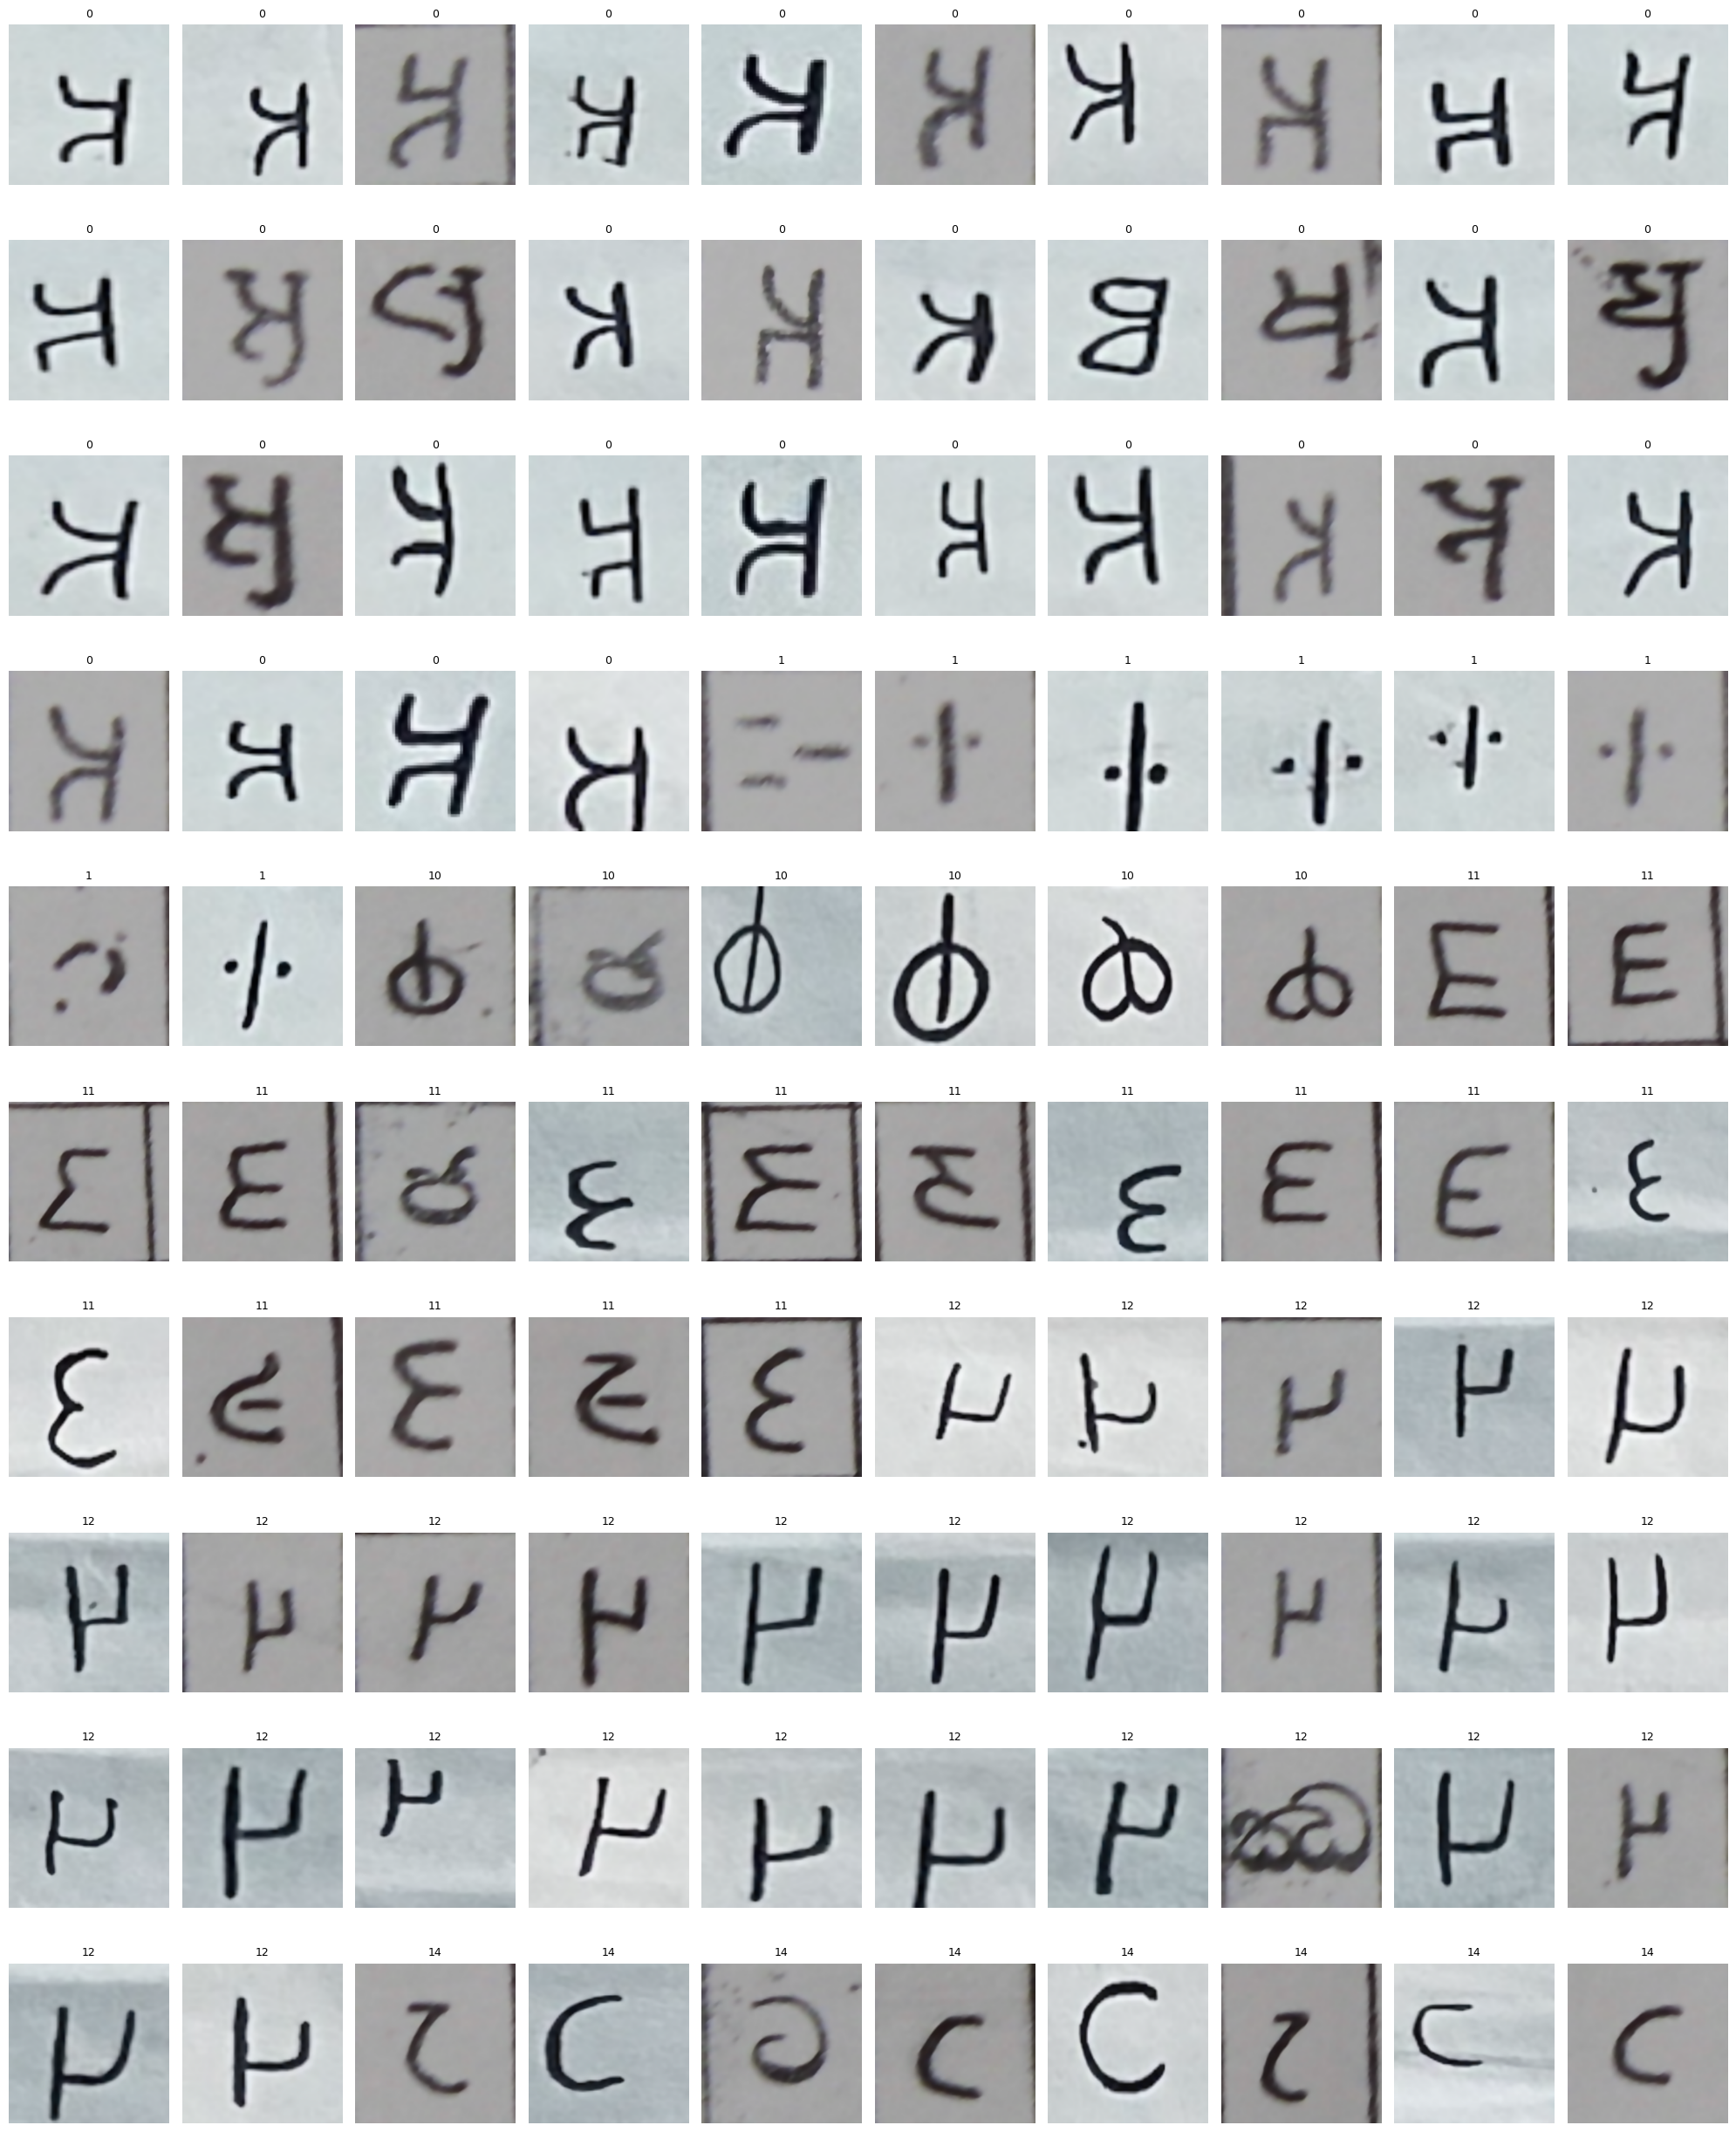

In [19]:
def plot_all_images(images, labels, max_images=100):
    total = min(len(images), max_images)
    cols = 10
    rows = total // cols + int(total % cols != 0)

    plt.figure(figsize=(20, 2.5 * rows))
    for i in range(total):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i], fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot the images
plot_all_images(X, y)


# Data Augmentation

In [11]:
def augment_image(image):
    rows, cols, _ = image.shape
    M_rot = cv2.getRotationMatrix2D((cols/2, rows/2), 15, 1)
    rotated = cv2.warpAffine(image, M_rot, (cols, rows))

    scaled = cv2.resize(image, None, fx=1.2, fy=1.2)
    scaled = cv2.resize(scaled, (224, 224))

    M_translate = np.float32([[1, 0, 20], [0, 1, 30]])  # Shift 20 pixels right and 30 pixels down
    translated = cv2.warpAffine(image, M_translate, (cols, rows))


    noise = np.random.normal(0, 15, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)

    return [image, rotated, scaled,  translated, noisy_image]

In [12]:
from PIL import Image, ImageOps

def preprocess_bw(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
    return thresh

def pad_image(image, border):
    pil_img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    padded = ImageOps.expand(pil_img, border=border, fill='white')
    return cv2.cvtColor(np.array(padded), cv2.COLOR_RGB2BGR)

def crop_image(image, crop_border):
    h, w = image.shape[:2]
    return image[crop_border:h - crop_border, crop_border:w - crop_border]

def rotate_image(image, angle, size):
    M = cv2.getRotationMatrix2D((size[0] / 2, size[1] / 2), angle, 1)
    return cv2.warpAffine(image, M, size, borderValue=(255, 255, 255))

def augment_image(image):
    rows, cols, _ = image.shape
    target_size = (cols, rows)

    # Base augmentations
    rotated_pos15 = rotate_image(image, 15, target_size)
    rotated_neg15 = rotate_image(image, -15, target_size)

    scaled = cv2.resize(image, None, fx=1.2, fy=1.2)
    scaled = cv2.resize(scaled, target_size, interpolation=cv2.INTER_AREA)

    M_translate = np.float32([[1, 0, 20], [0, 1, 30]])
    translated = cv2.warpAffine(image, M_translate, target_size, borderValue=(255, 255, 255))

    noise_std = 15
    noise = np.random.normal(0, noise_std, image.shape).astype(np.int16)
    noisy_image = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)

    # Extra noise
    noise_extra = np.random.normal(0, 30, image.shape).astype(np.int16)
    noisy_more = np.clip(image.astype(np.int16) + noise_extra, 0, 255).astype(np.uint8)

    # Paddings and their rotations
    padded_30 = cv2.resize(pad_image(image, 30), target_size)
    padded_60 = cv2.resize(pad_image(image, 60), target_size)
    padded_30_rot15 = rotate_image(padded_30, 15, target_size)
    padded_60_rot_neg15 = rotate_image(padded_60, -15, target_size)

    # Croppings and their rotations
    cropped_20 = cv2.resize(crop_image(image, 20), target_size)
    cropped_40 = cv2.resize(crop_image(image, 40), target_size)
    cropped_50 = cv2.resize(crop_image(image, 50), target_size)
    cropped_20_rot15 = rotate_image(cropped_20, 15, target_size)
    cropped_20_rot_neg15 = rotate_image(cropped_20, -15, target_size)

    # Collect all
    images = [
        image,
        rotated_pos15,
        rotated_neg15,
        scaled,
        translated,
        noisy_image,
        noisy_more,
        padded_30,
        padded_60,
        padded_30_rot15,
        padded_60_rot_neg15,
        cropped_20,
        cropped_40,
        cropped_50,
        cropped_20_rot15,
        cropped_20_rot_neg15
    ]

    # Convert all to binary black and white
    bw_images = [preprocess_bw(img) for img in images]

    return bw_images


In [20]:
X_aug = []
y_aug = []

for img, label in zip(X, y):

    augmented_images = augment_image(img)
    for aug_img in augmented_images:
        X_aug.append(aug_img)
        y_aug.append(label)


In [21]:
import numpy as np

X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

print("Augmented data shape:", X_aug.shape)


Augmented data shape: (17552, 224, 224)


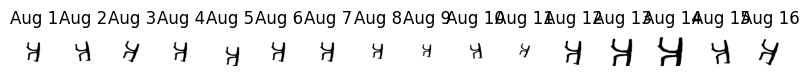

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
for i, img in enumerate(augment_image(X[3])):
    plt.subplot(1, 16, i + 1)
    plt.imshow(img, cmap='gray')  # Force grayscale display
    plt.title(f"Aug {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Feature Extraction with Pre-trained CNNs


In [23]:
def get_feature_extractors():
    models = {
        'vgg19': VGG19(weights='imagenet', include_top=False, pooling='avg'),
        'inceptionv3': InceptionV3(weights='imagenet', include_top=False, pooling='avg'),
        'resnet50': ResNet50(weights='imagenet', include_top=False, pooling='avg'),
        'inceptionresnetv2': InceptionResNetV2(weights='imagenet', include_top=False, pooling='avg')
    }
    return models


In [24]:
def extract_features(image, models):
    image = img_to_array(image)

    # Convert grayscale to RGB if needed
    if image.shape[-1] == 1:
        image = np.repeat(image, 3, axis=-1)

    image = np.expand_dims(image, axis=0)
    features = []

    for name, model in models.items():
        if name == 'vgg19':
            img = preprocess_vgg(image.copy())
        else:
            img = image / 255.0
        feat = model.predict(img, verbose=0)
        features.append(feat.flatten())

    return np.concatenate(features)


In [25]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Check GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Load models on GPU
with tf.device('/GPU:0'):
    models = get_feature_extractors()

    # Extract features
    X_features = [extract_features(img, models) for img in X_aug]
    X_features = np.array(X_features)



Num GPUs Available: 1
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


# Ensemble Classification


In [26]:
def train_classifiers(X, y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    rf = RandomForestClassifier(n_estimators=100)
    et = ExtraTreesClassifier(n_estimators=100)
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

    rf.fit(X_train, y_train)
    et.fit(X_train, y_train)
    xgb.fit(X_train, y_train)

    # Stacking prediction (simple majority voting here)
    preds = np.array([
        rf.predict(X_test),
        et.predict(X_test),
        xgb.predict(X_test)
    ])
    final_preds = np.round(np.mean(preds, axis=0)).astype(int)

    print(classification_report(y_test, final_preds, target_names=le.classes_))

    return rf, et, xgb, le


In [27]:
rf, et, xgb, le = train_classifiers(X_features, y_aug)


# Save models
import joblib
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(et, 'extra_trees_model.pkl')
joblib.dump(xgb, 'xgboost_model.pkl')
joblib.dump(le, 'label_encoder.pkl')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:46:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       109
           1       1.00      0.89      0.94        18
          10       1.00      0.88      0.94        17
          11       0.96      0.88      0.92        50
          12       0.93      0.90      0.92        91
          14       0.94      0.91      0.93        68
          15       0.62      0.73      0.67        11
          16       0.86      0.60      0.71        40
          17       0.62      0.29      0.40        17
          18       0.90      0.90      0.90       134
          19       0.94      0.95      0.95       123
           2       0.77      0.71      0.74        52
          20       0.50      0.72      0.59        18
          21       0.93      0.91      0.92       139
          22       0.51      0.81      0.63        26
          23       0.91      0.87      0.89       143
          24       0.86      0.76      0.81       135
          25       0.29    

['label_encoder.pkl']

# Mapping to Sinhala Characters



In [ ]:
corrected_class_map = {
    0: "අ", 1: "ඉ", 2: "උ", 3: "එ", 4: "ඔ",
    5: "ක", 6: "ඛ", 7: "ග", 8: "ඝ", 9: "ච", 10: "", 11: "ජ",
    12: " ", 14: "ට", 15: "ඨ", 16: "ඩ", 17: " ", 18: "ණ",
    19: "ත", 20: "ථ", 21: "ද", 22: " ", 23: "න", 24: "ප",
    25: " ", 26: "බ", 27: "භ", 28: "ම", 29: "ය",
    30: "ර", 31: "ල", 32: "ව", 33: "ශ", 35: "ස",
    36: "හ", 37: "ගා", 38: "හා", 39: "", 40: "වි", 41: "පි",
    42: "බි", 43: "ගි", 44: "පි", 45: "මි", 46: "ණි", 47: "ශි",
    48: "යි", 49: "පු", 50: "ටු", 51: "ශු", 52: "බු", 53: "දු",
    54: "නු", 55: "රි", 56: "ශි", 57: "ති", 58: "ඩි", 59: "දි",
    60: "කි", 61: "රී", 62: "නි", 63: "ඤි", 64: "ධි", 65: "ළ",
    66: "තු", 67: "ශු", 68: "පු", 69: "රු", 70: "බු", 71: "දු",
    72: "නු", 73: "ලු", 74: "චු", 75: "ලෙ", 76: "යෙ", 77: "දෙ",
    78: "නෙ", 79: "වෙ", 80: "ශෙ", 81: "ණෙ", 82: "කෙ", 83: "චෙ",
    84: "තෙ", 85: "පො", 86: "බො", 87: "ශො", 88: "ගො"
}


# Letter Prediction

In [ ]:

import random
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import LabelEncoder

# Load models and label encoder
rf = joblib.load('/kaggle/working/random_forest_model.pkl')
et = joblib.load('/kaggle/working/extra_trees_model.pkl')
xgb = joblib.load('/kaggle/working/xgboost_model.pkl')
le = joblib.load('/kaggle/working/label_encoder.pkl')

# Assuming you have these functions and arrays already defined:
# - get_feature_extractors()
# - extract_features(img, models)
# - X_aug (augmented image data)
# - y_aug (labels)

models = get_feature_extractors()

# Randomly pick N samples
# Ensure N does not exceed the length of X_aug
N = min(20, len(X_aug))

# Randomly pick N samples
random_indices = random.sample(range(len(X_aug)), N)




for i, idx in enumerate(random_indices):
    img = X_aug[idx]
    true_label = y_aug[idx]

    # Extract features
    features = extract_features(img, models).reshape(1, -1)

    # Predict
    rf_pred = rf.predict(features)[0]
    et_pred = et.predict(features)[0]
    xgb_pred = xgb.predict(features)[0]

    # Decode predictions and true label
    def decode(label):
        return le.inverse_transform([label])[0] if isinstance(label, (np.integer, int)) else label

    true_decoded = corrected_class_map.get(int(decode(true_label)), "Unknown")
    rf_decoded = corrected_class_map.get(int(decode(rf_pred)), "Unknown")
    et_decoded = corrected_class_map.get(int(decode(et_pred)), "Unknown")
    xgb_decoded = corrected_class_map.get(int(decode(xgb_pred)), "Unknown")

    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.axis('off')
    plt.show()


    print(f"T:{true_decoded}\nRF:{rf_decoded} ET:{et_decoded} XGB:{xgb_decoded}")



In [ ]:
from PIL import Image



models = get_feature_extractors()

# Provide your image path here
pathmage = "/kaggle/input/whaaaaaaaaaaaaaaaaaaa/WhatsApp Image 2025-05-31 at 15.12.03 (1).jpeg"
from PIL import Image, ImageOps

def load_image(path):
    img = Image.open(path).convert('RGB')

    # Add 25 pixels of white padding
    img = ImageOps.expand(img, border=50, fill='white')

    # Resize to model input size after padding (if needed)
    img = img.resize((224, 224))

    return np.array(img)


img = load_image(pathmage)

# Extract features
features = extract_features(img, models).reshape(1, -1)

# Predict
rf_pred = rf.predict(features)[0]
et_pred = et.predict(features)[0]
xgb_pred = xgb.predict(features)[0]

# Decode predictions
def decode(label):
    return le.inverse_transform([label])[0] if isinstance(label, (np.integer, int, np.int64)) else label

rf_decoded = corrected_class_map.get(int(decode(rf_pred)))
et_decoded = corrected_class_map.get(int(decode(et_pred)))
xgb_decoded = corrected_class_map.get(int(decode(xgb_pred)))

# Display results
plt.imshow(img)
plt.axis('off')

plt.show()

print(f"Predictions:\nRandom Forest: {rf_decoded}\nExtra Trees: {et_decoded}\nXGBoost: {xgb_decoded}")


In [ ]:
# from PIL import Image, ImageOps

# def load_image(path):
#     img = Image.open(path).convert('RGB')

#     # Add 25 pixels of white padding
#     img = ImageOps.expand(img, border=25, fill='white')

#     # Resize to model input size after padding (if needed)
#     img = img.resize((224, 224))

#     return np.array(img)


# Training for Eras

In [ ]:
# import cv2
# import numpy as np
# from PIL import Image, ImageOps

# def preprocess_bw(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     blurred = cv2.GaussianBlur(gray, (5, 5), 0)
#     _, thresh = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
#     return thresh

# def pad_image(image, border):
#     # Ensure image is uint8
#     if image.dtype != np.uint8:
#         image = np.clip(image, 0, 255).astype(np.uint8)

#     # Skip if image is too small
#     if image.shape[0] < 2 or image.shape[1] < 2:
#         print(f"⚠️ Skipping padding: image too small ({image.shape})")
#         return image

#     try:
#         pil_img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#         padded = ImageOps.expand(pil_img, border=border, fill='white')
#         padded_np = np.array(padded)
#         # Ensure final padded image is uint8
#         padded_np = np.clip(padded_np, 0, 255).astype(np.uint8)
#         return cv2.cvtColor(padded_np, cv2.COLOR_RGB2BGR)
#     except Exception as e:
#         print(f"❌ pad_image error: {e}")
#         return image


# def crop_image(image, crop_border):
#     h, w = image.shape[:2]
#     return image[crop_border:h - crop_border, crop_border:w - crop_border]

# def rotate_image(image, angle, size):
#     M = cv2.getRotationMatrix2D((size[0] / 2, size[1] / 2), angle, 1)
#     return cv2.warpAffine(image, M, size, borderValue=(255, 255, 255))



# def augment_image(image):
#     rows, cols, _ = image.shape
#     target_size = (cols, rows)

#     # Base augmentations
#     rotated_pos15 = rotate_image(image, 15, target_size)
#     rotated_neg15 = rotate_image(image, -15, target_size)

#     scaled = cv2.resize(image, None, fx=1.2, fy=1.2)
#     scaled = cv2.resize(scaled, target_size, interpolation=cv2.INTER_AREA)

#     M_translate = np.float32([[1, 0, 20], [0, 1, 30]])
#     translated = cv2.warpAffine(image, M_translate, target_size, borderValue=(255, 255, 255))

#     noise_std = 15
#     noise = np.random.normal(0, noise_std, image.shape).astype(np.int16)
#     noisy_image = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)



#     padded_30 = cv2.resize(pad_image(image, 30), target_size)
#     padded_60 = cv2.resize(pad_image(image, 60), target_size)
#     padded_30_rot15 = rotate_image(padded_30, 15, target_size)
#     padded_60_rot_neg15 = rotate_image(padded_60, -15, target_size)

#     cropped_20 = cv2.resize(crop_image(image, 20), target_size)
#     cropped_40 = cv2.resize(crop_image(image, 40), target_size)
#     cropped_50 = cv2.resize(crop_image(image, 50), target_size)
#     cropped_20_rot15 = rotate_image(cropped_20, 15, target_size)
#     cropped_20_rot_neg15 = rotate_image(cropped_20, -15, target_size)

#     images = [
#         image,
#         rotated_pos15,
#         rotated_neg15,
#         scaled,
#         translated,
#         noisy_image,

#         padded_30,
#         padded_60,
#         padded_30_rot15,
#         padded_60_rot_neg15,
#         cropped_20,
#         cropped_40,
#         cropped_50,
#         cropped_20_rot15,
#         cropped_20_rot_neg15
#     ]

#     bw_images = [preprocess_bw(img) for img in images]

#     bw_rgb_images = [cv2.cvtColor(bw_img, cv2.COLOR_GRAY2RGB) for bw_img in bw_images]

#     # Convert all images to uint8 (very important)
#     bw_rgb_images = [img.astype(np.uint8) for img in bw_rgb_images]

#     return bw_rgb_images



In [ ]:
# import numpy as np
# import os
# import joblib
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.applications import MobileNetV2

# # Assuming you have these functions defined elsewhere
# # from your_utils import load_dataset_kaggle, load_images_with_preprocessing, augment_image

# def process_and_train(dataset_num):
#     data_dir = f'/kaggle/input/lettereras/{dataset_num}'

#     if not os.path.exists(data_dir):
#         return  # skip if folder doesn't exist

#     try:
#         # Load and preprocess data
#         X, y = load_images_with_preprocessing(data_dir)

#         # Data augmentation
#         X_aug = []
#         y_aug = []
#         for img, label in zip(X, y):
#             augmented_images = augment_image(img)
#             for aug_img in augmented_images:
#                 X_aug.append(aug_img)
#                 y_aug.append(label)

#         X_aug = np.array(X_aug)
#         y_aug = np.array(y_aug)

#         # Encode labels
#         label_encoder = LabelEncoder()
#         y_encoded = label_encoder.fit_transform(y_aug)
#         y_categorical = to_categorical(y_encoded)

#         # Save label encoder
#         joblib.dump(label_encoder, f'/kaggle/working/label_encoder_{dataset_num}.pkl')


#         #X_aug = (X_aug / 255).astype(np.float32)
#         print(X_aug.shape)

#         # Train-test split
#         X_train, X_val, y_train, y_val = train_test_split(
#             X_aug, y_categorical, test_size=0.1,
#             stratify=y_encoded, random_state=36
#         )

#         # Build model
#         base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#         for layer in base_model.layers:
#             layer.trainable = False

#         x = base_model.output
#         x = GlobalAveragePooling2D()(x)
#         x = Dropout(0.5)(x)
#         x = Dense(128, activation='relu')(x)
#         x = Dropout(0.3)(x)
#         predictions = Dense(y_categorical.shape[1], activation='softmax')(x)

#         model = Model(inputs=base_model.input, outputs=predictions)
#         model.compile(
#             optimizer=Adam(learning_rate=1e-3),
#             loss='categorical_crossentropy',
#             metrics=['accuracy']
#         )

#         # Train model (no logs)
#         model.fit(
#             X_train, y_train,
#             validation_data=(X_val, y_val),
#             epochs=50,
#             batch_size=8,
#             verbose=1  # hide training logs
#         )

#         # Save model
#         model.save(f'/kaggle/working/model_{dataset_num}.h5')
#         print(f"✅ Done training & saving dataset {dataset_num}")

#     except Exception as e:
#         print(f"❌ Error with dataset {dataset_num}: {str(e)}")

# # Process all datasets from 0 to 36
# for i in range(37):  # 0 to 36 inclusive
#     process_and_train(i)

# print("🎉 All datasets processed successfully!")


# Era Prediction

In [ ]:
# import matplotlib.pyplot as plt

# def predict_image(dataset_num, image_path):
#     # Load model and label encoder
#     model = load_model(f'/kaggle/working/model_{dataset_num}.h5')
#     label_encoder = joblib.load(f'/kaggle/working/label_encoder_{dataset_num}.pkl')

#     # Load and preprocess the image
#     img = image.load_img(image_path, target_size=(224, 224))
#     img = np.array(img)  # Convert PIL to NumPy
#     img = preprocess_bw(img)  # Apply grayscale + thresholding
#     img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to 3-channel
#     img_array = img.astype(np.float32)
#     img_array = preprocess_input(img_array)
#     img_array = np.expand_dims(img_array, axis=0)

#     # Predict
#     preds = model.predict(img_array, verbose=0)[0]
#     predicted_class_index = np.argmax(preds)
#     predicted_label = label_encoder.inverse_transform([predicted_class_index])[0]

#     # Show image with prediction
#     plt.figure(figsize=(10, 4))

#     # Plot the image
#     plt.subplot(1, 2, 1)
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.title(f"🧠 Predicted: {predicted_label}")
#     plt.axis('off')

#     # Plot probabilities
#     plt.subplot(1, 2, 2)
#     class_labels = label_encoder.classes_
#     plt.barh(class_labels, preds)
#     plt.title("Class Probabilities")
#     plt.xlabel("Probability")
#     plt.tight_layout()
#     plt.show()


In [ ]:
predict_image(0, '/kaggle/input/lettereras/0/Apara Brahmiya/1.JPG')



In [ ]:
# from PIL import Image



# models = get_feature_extractors()

# # Provide your image path here
# pathmage = "/kaggle/input/lettereras/20/Early Brahmi/IMG_4005.JPG"
# # Load and preprocess the image
# def load_image(path):
#     img = Image.open(path).convert('RGB')
#     img = img.resize((224, 224))  # Resize if needed
#     return np.array(img)

# img = load_image(pathmage)

# # Extract features
# features = extract_features(img, models).reshape(1, -1)

# # Predict
# rf_pred = rf.predict(features)[0]
# et_pred = et.predict(features)[0]
# xgb_pred = xgb.predict(features)[0]

# # Decode predictions
# def decode(label):
#     return le.inverse_transform([label])[0] if isinstance(label, (np.integer, int, np.int64)) else label




# rf_decoded = corrected_class_map.get(int(decode(rf_pred)))
# et_decoded = corrected_class_map.get(int(decode(et_pred)))
# xgb_decoded = corrected_class_map.get(int(decode(xgb_pred)))



# # Display results
# plt.imshow(img)
# plt.axis('off')
# plt.show()

# print(f"Predictions:\nRandom Forest: {rf_decoded}\nExtra Trees: {et_decoded}\nXGBoost: {xgb_decoded}")


# if (rf_pred == et_pred) or (et_pred == xgb_pred) or (xgb_pred == rf_pred):
#     # Check which models are equal and use that one to predict
#     if rf_pred == et_pred:
#         predict_image(rf_pred, pathmage)
#     elif et_pred == xgb_pred:
#         predict_image(et_pred, pathmage)  # Use et or xgb as they are the same
#     elif rf_pred == xgb_pred:
#         predict_image(rf_pred, pathmage)  # Use rf or xgb as they are the same

